### Project:  SMS Spam filter Classifier

*Submitted By: Bharath Karumudi.*

For this assignment I have selected the dataset "SMS Spam Collection" from Kaggle: https://www.kaggle.com/uciml/sms-spam-collection-dataset  and will be performing a classification problem by comparing with different models and see which model performed bettter.

### 1. Building a Spam Classifier

We can build a Spam classifier by using the probability theory - Baye's theorem, which we can express as:
P(A|B) = P(B|A) * P(A) / P(B). 
We’ll train our filter using a collection of spam and non-spam(aka “ham”) SMS. So, we’ll provide right answers to train the filter, and later in the prediction phase, its output for a given message would be either “spam” or “ham”. So, this filter is an example of a supervised classification algorithm.

Several models are built to predit the SMS Spam classifier and the framework follows as below:
<img src="model-framework.png">

#### Additonal work included:
1. Added lemmantization
2. added feature avg. len of words in sms
3. added feature len of sms
4. added frequency of capitals in the sms.
5. Applied StratifiedCV in GridSearch for internal CV.

#### Loading the required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn import metrics, svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr 
import xgboost as xgb

import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/bharathkarumudi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

### 2. About Dataset
The dataset is a SMS Spam collection that was collected for SMS Spam research and have 5,574 English messages and tagged as ham or spam.
The file contains, two columns: V1 contains the label and V2 contains the SMS.

### 3. Inspecting the dataset 

#### Loading the dataset
Let's load the dataset which is a csv file and then visualize how it is.

In [3]:
dat = pd.read_csv('data/spam.csv', encoding='latin-1')

In [4]:
print ("Number of records in the dataset: " + str(dat.shape[0]))
print ("\nLet's see sample records from dataset:")
dat.head()

Number of records in the dataset: 5572

Let's see sample records from dataset:


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Statistics on the dataset:

In [5]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


Data Distribution:


Text(0.5, 1.0, 'Number of ham and spam messages')

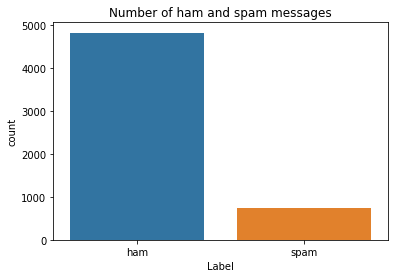

In [6]:
print("Data Distribution:")
sns.countplot(dat.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

From above we can see, we have a corpus of 5,572 records written in English and also has a target variable in first column which tells whether the message is a Spam or Ham and the second column is a text message which is in English.

The last three are NaN which are not useful.

It looks like there are far fewer training examples for spam than ham—we'll take this imbalance into account in the analysis.



### 4. Preprocessing the data

Let's rename the columns as 'Y' and 'SMS' and replacing the ham with 0 and Spam with 1 and dropping the columns that are not required:

In [7]:
dat = dat.loc[:, ['v1', 'v2']]
dat.rename(columns={'v1': 'y', 'v2': 'sms'}, inplace=True)
dat.y = dat.y.replace({'ham': 0, 'spam': 1})
dat.head()

,y,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
def preprocess_txt(raw_text):
    
    processed = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr')
    processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr')
    processed = processed.str.replace(r'£|\$', 'moneysymb')    
    processed = processed.str.replace(r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr')
    processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

    processed = processed.str.replace(r'[^\w\d\s]', ' ')
    processed = processed.str.replace(r'\s+', ' ')
    processed = processed.str.replace(r'^\s+|\s+?$', '')

    processed = processed.str.lower()
    
    return processed

In [9]:
processed = preprocess_txt(dat.sms)

Removing the stop words which do not add value, create ngrams and also filter the words that appears in almost all or very less apperance. 

Some words in the English language, while necessary, don't contribute much to the meaning of a phrase. These words, such as "when", "had", "those" or "before", are called stop words and should be filtered out. 

We can tokenize individual terms and generate what's called a bag of words model. You may notice this model has a glaring pitfall: it fails to capture the innate structure of human language. Under this model, the following sentences have the same feature vector although they convey dramatically different meanings.

    Does steak taste delicious?
    Steak does taste delicious.

Alternatively, we can tokenize every sequence of n
terms called n-grams. For example, tokenizing adjacent pairs of words yields bigrams. The n

-gram model preserves word order and can potentially capture more information than the bag of words model.

To get the best of both worlds, let's tokenize unigrams and bigrams. As an example, unigrams and bigrams for "The quick brown fox" are "The", "quick", "brown", "fox", "The quick", "quick brown" and "brown fox".

In [10]:
# One hot encode words
vec = TfidfVectorizer(tokenizer=LemmaTokenizer(),
                      stop_words='english', # Remove stop words like a, an, the, etc that do not add much value.
                      ngram_range=(1, 2),   # create unigrams and bigrams.
                      min_df=0.01,          # filter words that appear in less than 1% of records
                      max_df=0.99)          # filter words that appear in more than 99% of records.

X = vec.fit_transform(processed)

In [11]:
message_len = dat.sms.apply(len).values
message_len = message_len / max(message_len)

message_n_words = np.array([len(x) for x in dat.sms.str.split()])
message_n_words = message_n_words / max(message_n_words)

all_caps_freq = np.array([sum(1 for c in message if c.isupper()) for message in dat.sms]) / message_len

avg_word_len = []
for message in dat.sms.str.split():
    message_word_lens = []
    for word in message:
        message_word_lens.append(len(word))
    avg_word_len.append(np.mean(message_word_lens))
avg_word_len = np.array(avg_word_len)

In [12]:

corr_coef, p = pearsonr(message_len, message_n_words) # highly correlated

print('Correlation coeff of {0} is greater than 0.9.'.format(corr_coef))
print('So we will only use count of words in a message feature.')

Correlation coeff of 0.973724569719385 is greater than 0.9.
So we will only use count of words in a message feature.


In [13]:
X = np.column_stack((X.todense(), message_n_words, all_caps_freq, avg_word_len))
X_column_names = vec.get_feature_names() + ['message_n_words', 'all_caps_freq', 'avg_word_len']

### 5. Creating the train and test datasets:
Using stratification on target variable creating 90% train and 10% test datasets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, dat.y, test_size=0.1, stratify=dat.y, random_state=1234)

### 6. Building the Models

#### Training the model using SVM

In [15]:
# We will be training the model with range of parameters and from 
# there we can get the best model out of it.
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

grid_search_svm = GridSearchCV(SVC(kernel='rbf', random_state=1234, class_weight='balanced'), 
                               param_grid,
                               scoring=make_scorer(f1_score),
                               cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
                              ).fit(X=X_train, y=y_train)

#### Let's see the model score:

In [16]:
grid_search_svm.best_estimator_.score(X_test, y_test)

0.9587813620071685

In [17]:
# predict using the best model
svm_y_pred = grid_search_svm.best_estimator_.predict(X_test)

# Build Confusion Matrix
svm_cfm = pd.DataFrame(
    metrics.confusion_matrix(y_test, svm_y_pred),
    index=[['actual', 'actual'], ['spam', 'ham']],
    columns=[['predicted', 'predicted'], ['spam', 'ham']]
)

### Training the model using Random Forest Classifier

In [18]:
# We will be training the model with range of parameters and from 
# there we can get the best model out of it.

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

param_grid = dict(n_estimators = n_estimators, 
              max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf)

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=1234, class_weight='balanced'), 
                     param_grid, 
                     cv = 3, 
                     scoring=make_scorer(f1_score),
                     n_jobs = -1).fit(X_train, y_train)

#### Let's see the model score:

In [19]:
grid_search_rf.best_estimator_.score(X_test, y_test)

0.9767025089605734

In [20]:
# predict using the best model
rf_y_pred=grid_search_rf.best_estimator_.predict(X_test)

# Build Confusion Matrix
rf_cfm = pd.DataFrame(
    metrics.confusion_matrix(y_test, rf_y_pred),
    index=[['actual', 'actual'], ['spam', 'ham']],
    columns=[['predicted', 'predicted'], ['spam', 'ham']]
)

### Training using Naive Bayes Classifier

In [21]:
cnb = ComplementNB(alpha=0.1).fit(X_train, y_train)
nb_y_pred = cnb.predict(X_test)
score = f1_score(y_pred=nb_y_pred, y_true=y_test, pos_label=1)
    
print(score)

0.7570621468926553


In [22]:
# Build Confusion Matrix
nb_cfm = pd.DataFrame(
    metrics.confusion_matrix(y_test, nb_y_pred),
    index=[['actual', 'actual'], ['spam', 'ham']],
    columns=[['predicted', 'predicted'], ['spam', 'ham']]
)

### Training using Gradient Boosting Classifier

In [23]:
data_tr  = xgb.DMatrix(X_train, label=y_train)
data_val  = xgb.DMatrix(X_test, label=y_test)
evallist = [(data_tr, 'train'), (data_val, 'test')]

parms = {'max_depth':9,      #maximum depth of a tree
         'objective':'binary:logistic',
         'eta'      :0.1,
         'subsample':0.8,    #SGD will use this percentage of data
         'lambda '  :1.5,    #L2 regularization term, >1 more conservative
         'colsample_bytree ':0.8,
         'nthread'  :3}      #number of cpu core to use

GBM = xgb.train(parms, data_tr, num_boost_round=118, evals = evallist,
                maximize=False, verbose_eval=False)


Acc = {}
F1score = {}
confusion_mat={}
predictions = {}
name = 'GBM'
pred = GBM.predict(xgb.DMatrix(X_test))
pred = [int(round(p)) for p in pred]
F1score[name]= f1_score(y_test,pred)
Acc[name] = accuracy_score(y_test,pred)
confusion_mat[name] = confusion_matrix(y_test,pred)
predictions[name]=pred
print(name+': Accuracy=%1.3f, F1=%1.3f'%(Acc[name],F1score[name]))

GBM: Accuracy=0.977, F1=0.909


In [24]:
# Build Confusion Matrix
gb_cfm = pd.DataFrame(
    metrics.confusion_matrix(y_test, pred),
    index=[['actual', 'actual'], ['spam', 'ham']],
    columns=[['predicted', 'predicted'], ['spam', 'ham']]
)

### 7. Evaluation

Now we have built models using different algorithms. Lets compare their performance and evaluate.

In [25]:
print("Confusion Matrix for SVM:\n\n", svm_cfm)

Confusion Matrix for SVM:

             predicted    
                 spam ham
actual spam       476   7
       ham         16  59


In [26]:
print("Confusion Matrix for Random Forest:\n\n", rf_cfm)

Confusion Matrix for Random Forest:

             predicted    
                 spam ham
actual spam       480   3
       ham         10  65


In [27]:
print("Confusion Matrix for Naive Bayes:\n\n", nb_cfm)

Confusion Matrix for Naive Bayes:

             predicted    
                 spam ham
actual spam       448  35
       ham          8  67


In [28]:
print("Confusion Matrix for Gradient Boosting:\n\n", gb_cfm)

Confusion Matrix for Gradient Boosting:

             predicted    
                 spam ham
actual spam       480   3
       ham         10  65


### 8. Decision

From the above confusion matrices, we can see the model that best suits is by Gradient Boosting. It has better score and better predictions compared to other models. Random Forest is also similar, but performanace wise it took time to build the model compared to the Gradient Boosting. The decisions are also depends on the business needs, because, in some cases, predicting a Spam as Ham will not impact much, but the other way around might impact, because there will be a loss of information. In some critical environment, where the security is higher, the False Negatives (predicting as Ham) is acceptable. 

### 9. Reference and work done:

[1] https://inmachineswetrust.com/posts/sms-spam-filter/  
[2] https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

Additonal work included:
1. Added lemmantization  
2. added feature avg. len of words in sms  
3. added feature len of sms.  
4. added frequency of capitals in the sms.  
5. Applied StratifiedCV in GridSearch for internal CV.  